In [1]:
import numpy as np
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.avragg as avragg
import mlgrad.gd as gd
import mlgrad.regular as regular
import mlgrad.weights as weights
from mlgrad.utils import array_exclude_outliers

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk

#import sklearn.linear_model as sklm

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

import sys
print(sys.version)

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: mlgrad.risk.Functional size changed, may indicate binary incompatibility. Expected 456 from C header, got 472 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: mlgrad.risk.SimpleFunctional size changed, may indicate binary incompatibility. Expected 456 from C header, got 472 from PyObject
  return f(*args, **kwds)


3.7.6 (default, Jan 19 2020, 22:34:52) 
[GCC 9.2.1 20200117]


3.8180654102569447


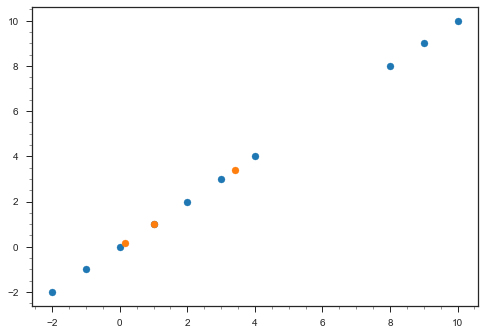

In [2]:
X = np.array([-2,-1,0,1,2,3,4,8,9,10], 'd')
avg0 = averager_it(func.QuantileFunc(0.6, func.Sqrt(0.001)))
avg = avragg.MHAverage(avg0)
avg.fit(X)
u = avg.u
u1 = np.mean(X[:-3])
u2 = np.mean(X)

Z = np.abs(X - u)
avg0.fit(Z)
print(avg0.u)

plt.scatter(X, X)
plt.scatter([u,u1,u2], [u,u1,u2])
plt.minorticks_on()
plt.show()

In [3]:
df = pd.read_csv("data/starsCYG.csv", sep=',', usecols=["log.Te", "log.light"], )

In [4]:
len(df)

47

In [5]:
Y = df["log.light"].values
X = df["log.Te"].values

X -= X.mean()
Y -= Y.mean()
# x_min, x_max = X.min(), X.max()
# X = (X - x_min) / (x_max - x_min)
# y_min, y_max = Y.min(), Y.max()
# Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

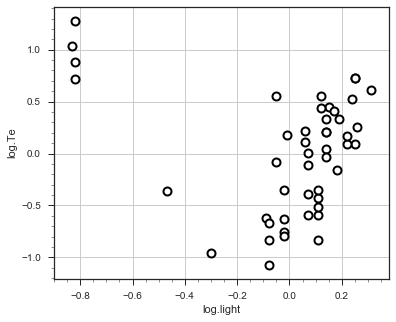

In [6]:
plt.figure(figsize=(6.0, 5.0))
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=2.)
plt.minorticks_on()
plt.grid(1)
plt.ylabel('log.Te')
plt.xlabel('log.light')
plt.show()

In [7]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())

In [8]:
mod1 = model.LinearModel(1)
mod1.init_param()

Completed? True


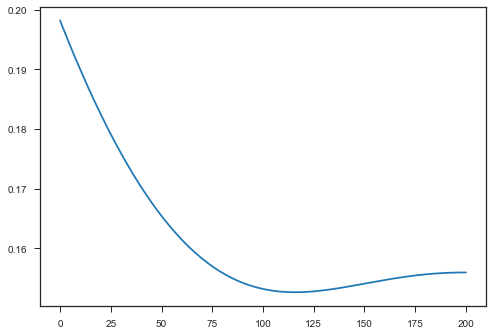

In [9]:
er1 = erisk(Xs, Y, mod1, loss_func_sq)
alg_fg1 = erm_fg(er1, h=0.01, tol=1.0e-6, verbose=0)
print("Completed?", alg_fg1.completed)

plt.plot(alg_fg1.lvals)
plt.show()

In [74]:
mod2 = model.LinearModel(1)
mod2.init_param()

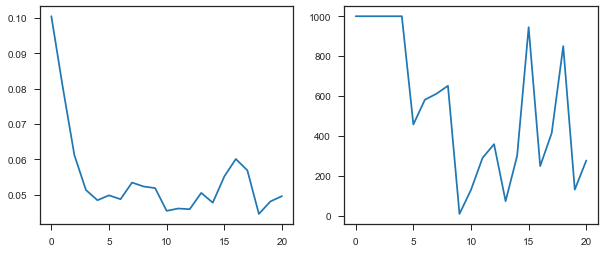

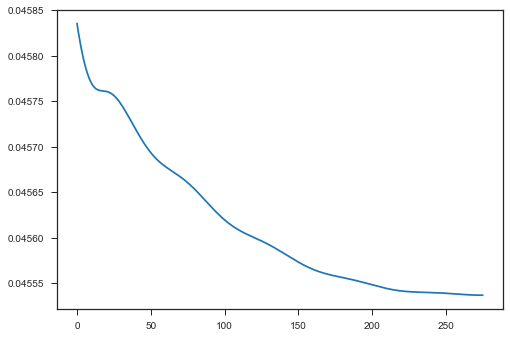

In [75]:
er2 = erisk(Xs, Y, mod2, loss_func_sq)
alg_fg2 = fg(er2, h=0.001, tol=1.0e-8)
avg2 = averager_it(func.QuantileFunc(0.75, func.Sqrt(0.001)))
avg2 = avragg.MHAverage(avg2)
wg2 = weights.MWeights(avg2, er2)
irgd2 = erm_irgd(alg_fg2, wg2, n_iter=21, tol=1.0e-5, verbose=0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(irgd2.lvals)
plt.subplot(1,2,2)
plt.plot(irgd2.n_iters)
plt.show()
plt.plot(alg_fg2.lvals)

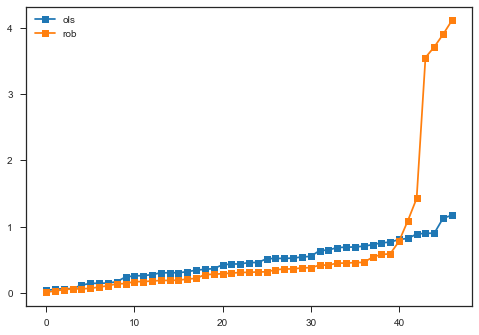

In [76]:
res1 = np.abs(Y - mod1.evaluate_all(Xs))
res1.sort()
res2 = np.abs(Y - mod2.evaluate_all(Xs))
res2.sort()
plt.plot(res1, marker='s', label='ols')
plt.plot(res2, marker='s', label='rob')
plt.legend()
plt.show()

In [77]:
Err = np.abs(Y - mod2.evaluate_all(Xs))

X1, X1_ = array_exclude_outliers(X, Err, 7) 
Y1, Y1_ = array_exclude_outliers(Y, Err, 7) 
X1s = X1.reshape(-1,1)

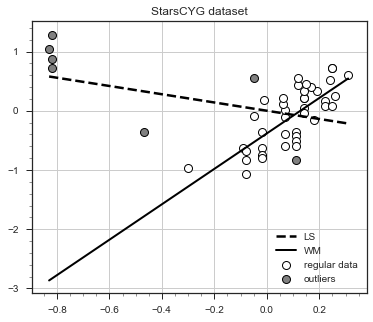

In [78]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X1, Y1, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X1_, Y1_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
X0 = np.linspace(X.min(), X.max(), 20)
plt.plot(X0, mod1.evaluate_all(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS')
plt.plot(X0, mod2.evaluate_all(X0.reshape(-1,1)), color='k', linewidth=2., label=r'WM')
plt.minorticks_on()
plt.grid(1)
#plt.xlabel('log.Te')
#plt.ylabel('log.light')
#plt.xlim(-0.05, 1.1)
plt.legend(loc='best')
plt.show()

In [15]:
mod3 = model.LinearModel(1)
mod3.init_param()

Completed? True


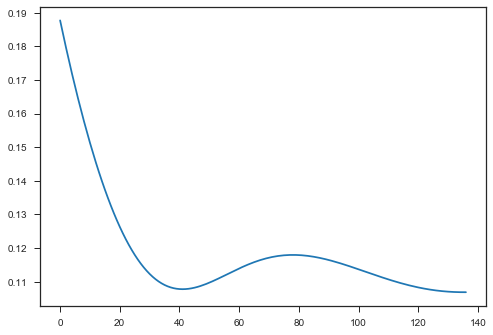

In [16]:
er3 = erisk(X1s, Y1, mod3, loss_func_sq)
alg_fg3 = erm_fg(er3, h=0.01, tol=1.0e-6, verbose=0)
print("Completed?", alg_fg3.completed)

plt.plot(alg_fg3.lvals)
plt.show()

In [33]:
mod4 = model.LinearModel(1)
mod4.init_param()

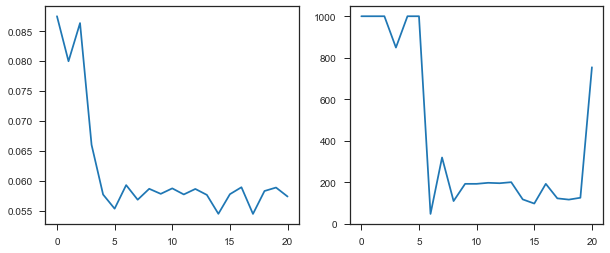

In [34]:
er4 = erisk(X1s, Y1, mod4, loss_func_sq)
alg_fg4 = fg(er4, h=0.001, tol=1.0e-7)
avg4 = averager_it(func.QuantileFunc(0.85, func.Sqrt(0.001)))
avg4 = avragg.MWAverage2(avg4)
wg4 = weights.MWeights(avg4, er4)
irgd4 = erm_irgd(alg_fg4, wg4, n_iter=21, tol=1.0e-5, verbose=0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(irgd4.lvals)
plt.subplot(1,2,2)
plt.plot(irgd4.n_iters)
plt.show()
# plt.plot(alg_fg2.lvals)

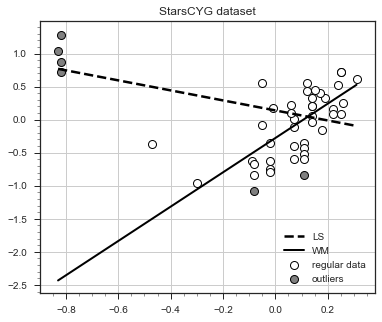

In [35]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X1, Y1, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X1_, Y1_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
X0 = np.linspace(X.min(), X.max(), 20)
plt.plot(X0, mod3.evaluate_all(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS')
plt.plot(X0, mod4.evaluate_all(X0.reshape(-1,1)), color='k', linewidth=2., label=r'WM')
plt.minorticks_on()
plt.grid(1)
plt.legend(loc='best')
plt.show()

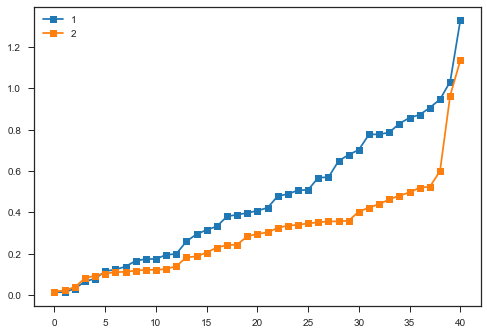

In [36]:
res3 = np.abs(Y1 - mod3.evaluate_all(X1s))
res3.sort()
res4 = np.abs(Y1 - mod4.evaluate_all(X1s))
res4.sort()
plt.plot(res3, marker='s', label='1')
plt.plot(res4, marker='s', label='2')
plt.legend()
plt.show()

In [42]:
40/47

0.851063829787234